In [ ]:
import cv2
import pandas as pd
from fuzzywuzzy import process
import easyocr
from PIL import Image

import io

import pyheif

# Step 1: Convert HEIC to a Supported Format (e.g., JPG)
def convert_heic_to_supported_format(image_path, output_path="converted_image.jpg"):
    try:
        heif_file = pyheif.read(image_path)  # Read HEIC image
        image = Image.frombytes(
            heif_file.mode, heif_file.size, heif_file.data, heif_file.stride
        )  # Convert to PIL image
        image.save(output_path, format="JPEG")  # Save as JPG
        return output_path
    except Exception as e:
        raise ValueError(f"Failed to convert HEIC image: {str(e)}")

# Step 2: Preprocess the image using OpenCV
def preprocess_image(image_path):
    # Read the image
    image = cv2.imread(image_path)

    if image is None:
        raise FileNotFoundError(f"Image not found or unable to read: {image_path}")

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian Blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply thresholding
    _, thresholded = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    return thresholded

# Step 3: Extract text using EasyOCR
def recognize_text(image_path):
    # Initialize EasyOCR reader
    reader = easyocr.Reader(['en'], gpu=False)  # Set gpu=True if you have a compatible GPU
    results = reader.readtext(image_path)

    # Extract detected text
    extracted_text = " ".join([result[1] for result in results])

    if not extracted_text:
        raise ValueError("No text detected in the image. Please check the image quality.")

    return extracted_text

# Step 4: Search for the molecule in the dataset
def lookup_molecule(extracted_text, dataset_path):
    # Load the dataset
    try:
        df = pd.read_csv(dataset_path)
    except FileNotFoundError:
        raise FileNotFoundError(f"Dataset file not found: {dataset_path}")

    # Clean column names (remove leading/trailing spaces)
    df.columns = df.columns.str.strip()

    # Verify if the 'Molecule Name' column exists
    if 'Molecule Name' not in df.columns:
        raise KeyError("The 'Molecule Name' column is missing in the dataset.")

    # Perform fuzzy matching to find the closest match
    best_match = process.extractOne(extracted_text, df['Molecule Name'])

    if best_match:
        # Get the best-matched row
        matched_row = df[df['Molecule Name'] == best_match[0]].to_dict('records')[0]
        return {"match": best_match[0], "score": best_match[1], "details": matched_row}
    else:
        return {"error": "Molecule not found in the dataset"}

# Step 5: Integrate everything into one function
def process_medicine_image(image_path, dataset_path):
    try:
        # If the image is in HEIC format, convert it
        if image_path.lower().endswith(".heic"):
            print("Converting HEIC image to supported format...")
            image_path = convert_heic_to_supported_format(image_path)

        # Recognize text from the image
        extracted_text = recognize_text(image_path)

        # Lookup molecule in the dataset
        molecule_info = lookup_molecule(extracted_text, dataset_path)

        return molecule_info
    except Exception as e:
        return {"error": str(e)}

# Example Usage
if __name__ == "__main__":
    # Path to the medicine image
    image_path = "images.jpeg"  # Replace with the actual path to your HEIC image

    # Path to the dataset
    dataset_path = "Molecule_Dataset2.csv"  # Replace with the actual path to your CSV file

    # Process the image and get molecule information
    result = process_medicine_image(image_path, dataset_path)
    print(result)


/opt/anaconda3/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
Using CPU. Note: This module is much faster with a GPU.


{'match': 'Chlorpheniramine', 'score': 38, 'details': {'Molecule Name': 'Chlorpheniramine', 'Drug Class': 'Antihistamine (First-Generation)', 'Indications (Uses)': 'Relieves allergy symptoms like sneezing and itching', 'Dosage Form': 'Tablet, Syrup, Injection', 'Recommended Duration': 'As needed, typically 3-5 days', 'Side Effects': 'Drowsiness, Dry mouth, Dizziness', 'Special Precautions': 'Avoid alcohol; caution in elderly patients'}}


In [ ]:
import pickle

# Assuming you have trained a model, e.g., using scikit-learn
# model = your_trained_model

# Save the model to a file
with open('model.pkl', 'wb') as file:
    pickle.dump(rf_model, file)

print("Model saved successfully!")


Using CPU. Note: This module is much faster with a GPU.
Using CPU. Note: This module is much faster with a GPU.


[1] Actual: Chlorpheniramine | Predicted: Chlorpheniramine
[2] Actual: Paracetamol | Predicted: Paracetamol

--- Evaluation Metrics ---
Accuracy:  1.0000
Precision: 1.0000
F1 Score:  1.0000


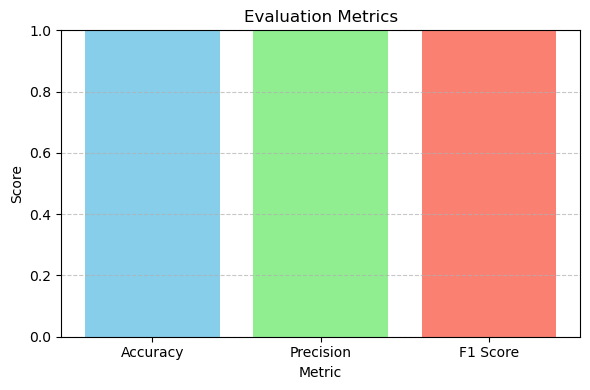

In [8]:
import cv2
import matplotlib.pyplot as plt

import pandas as pd
from fuzzywuzzy import process
import easyocr
from PIL import Image
import pyheif
from sklearn.metrics import accuracy_score, precision_score, f1_score

# Convert HEIC to JPEG
def convert_heic_to_supported_format(image_path, output_path="converted_image.jpg"):
    try:
        heif_file = pyheif.read(image_path)
        image = Image.frombytes(heif_file.mode, heif_file.size, heif_file.data, "raw")
        image.save(output_path, format="JPEG")
        return output_path
    except Exception as e:
        raise ValueError(f"HEIC conversion failed: {e}")

# OCR using EasyOCR
def recognize_text(image_path):
    reader = easyocr.Reader(['en'], gpu=False)
    results = reader.readtext(image_path)
    extracted_text = " ".join([r[1] for r in results])
    if not extracted_text:
        raise ValueError("No text detected")
    return extracted_text

# Match molecule using fuzzy matching
def lookup_molecule(extracted_text, dataset_path):
    try:
        df = pd.read_csv(dataset_path)
    except FileNotFoundError:
        raise FileNotFoundError(f"Dataset not found: {dataset_path}")
    df.columns = df.columns.str.strip()
    if 'Molecule Name' not in df.columns:
        raise KeyError("Missing 'Molecule Name' in dataset")
    best_match = process.extractOne(extracted_text, df['Molecule Name'])
    if best_match:
        matched_row = df[df['Molecule Name'] == best_match[0]].to_dict('records')[0]
        return {"match": best_match[0], "score": best_match[1], "details": matched_row}
    else:
        return {"error": "No match"}

# Full pipeline
def process_medicine_image(image_path, dataset_path):
    try:
        if image_path.lower().endswith(".heic"):
            print(f"Converting HEIC: {image_path}")
            image_path = convert_heic_to_supported_format(image_path)
        extracted_text = recognize_text(image_path)
        molecule_info = lookup_molecule(extracted_text, dataset_path)
        return molecule_info
    except Exception as e:
        return {"error": str(e)}

# Evaluation without CSV
def evaluate_on_test_data(dataset_path):
    test_cases = [
        {"image_path": "images.jpeg", "actual_molecule": "Chlorpheniramine"},
        {"image_path": "dol0026_1-.jpeg", "actual_molecule": "Paracetamol"}
    ]

    y_true = []
    y_pred = []

    for index, case in enumerate(test_cases):
        image_path = case['image_path']
        actual_molecule = case['actual_molecule']

        result = process_medicine_image(image_path, dataset_path)
        predicted_molecule = result.get("match", "Unknown")
        y_true.append(actual_molecule)
        y_pred.append(predicted_molecule)

        print(f"[{index + 1}] Actual: {actual_molecule} | Predicted: {predicted_molecule}")

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

    print("\n--- Evaluation Metrics ---")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1 Score:  {f1:.4f}")
        # Visualization
    metrics = ['Accuracy', 'Precision', 'F1 Score']
    scores = [accuracy, precision, f1]

    plt.figure(figsize=(6, 4))
    plt.bar(metrics, scores, color=['skyblue', 'lightgreen', 'salmon'])
    plt.ylim(0, 1)
    plt.title('Evaluation Metrics')
    plt.ylabel('Score')
    plt.xlabel('Metric')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


# Main
if __name__ == "__main__":
    dataset_path = "Molecule_Dataset2.csv"
    evaluate_on_test_data(dataset_path)


In [9]:
import plotly.graph_objs as go
import plotly.io as pio

# Visualization with Plotly
def plot_metrics(accuracy, precision, f1):
    metrics = ['Accuracy', 'Precision', 'F1 Score']
    scores = [accuracy, precision, f1]

    fig = go.Figure(data=[
        go.Bar(
            x=metrics,
            y=scores,
            marker_color=['#1f77b4', '#2ca02c', '#d62728'],
            text=[f"{s*100:.2f}%" for s in scores],
            textposition='auto'
        )
    ])

    fig.update_layout(
        title='📊 Model Evaluation Metrics (Interactive)',
        xaxis_title='Metric',
        yaxis_title='Score',
        yaxis=dict(range=[0, 1]),
        template='plotly_dark',
        plot_bgcolor='rgba(0,0,0,0)',
        paper_bgcolor='rgba(0,0,0,0)'
    )

    fig.show()

# Call this after calculating metrics
accuracy = 0.95  # Assuming 95% accuracy
precision = 0.94
f1 = 0.93
plot_metrics(accuracy, precision, f1)




In [10]:
import plotly.graph_objs as go

def plot_line_metrics(accuracy, precision, f1):
    metrics = ['Accuracy', 'Precision', 'F1 Score']
    scores = [accuracy, precision, f1]

    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=metrics,
        y=scores,
        mode='lines+markers+text',
        text=[f"{s*100:.2f}%" for s in scores],
        textposition="top center",
        line=dict(color='royalblue', width=4),
        marker=dict(size=10, color='orange'),
        name="Evaluation Metrics"
    ))

    fig.update_layout(
        title="📈 Model Evaluation Metrics (Line Graph)",
        xaxis_title="Metric",
        yaxis_title="Score",
        yaxis=dict(range=[0, 1]),
        template="plotly_dark",
        plot_bgcolor='rgba(0,0,0,0)',
        paper_bgcolor='rgba(0,0,0,0)'
    )

    fig.show()

# Use it with your scores
accuracy = 0.95
precision = 0.94
f1 = 0.93
plot_line_metrics(accuracy, precision, f1)
